In [13]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

import numpy as np

from relaxed.fits import get_early_late
from relaxed.mah import get_mah
from relaxed.models import opcam_dict
from relaxed.models import prepare_datasets
from relaxed.models import training_suite
import relaxed.plotting as rxplots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [14]:
params = ("cvir", "cvir_klypin", "t/|u|", "x0", "b_to_a", "c_to_a", "spin_bullock")
mah_data = get_mah("../../data/processed/bolshoi_m12", cutoff_missing=0.05, cutoff_particle=0.05)

cat = mah_data["cat"]
ma = mah_data["ma"]
am = mah_data["am"]
scales = mah_data["scales"]
mass_bins = mah_data["mass_bins"]

# prepare catalog with all m_a
ma_names = [f"ma_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(ma[:, ii], name=ma_names[ii])

# prepare catalog with all a_m
am_names = [f"am_{ii}" for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])



# load diffmah fits parameters
pars = np.load('../../data/processed/pbest_diffmah.npy')
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
early, late = get_early_late(ue, ul)
cat.add_column(10**logtc, name="tau_c")
cat.add_column(early, name="alpha_early")
cat.add_column(late, name="alpha_late")



In [15]:
# load diffmah fits curves.
diffmah_curves = np.load('../../data/processed/diffmah_fits.npy')
ma_diffmah_names = [f"ma_diffmah_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(diffmah_curves[:, ii], name=ma_diffmah_names[ii])

In [16]:

info = {
    "ma": {
        "x": ma_names,
        "y": params,
    },
    "am": { 
        'x': am_names, 
        'y': params,
    },
    "diffmah_curves": {
        "x": ma_diffmah_names,
        "y": params,
    },
    "diffmah_params": {
        "x": ("tau_c", "alpha_early", "alpha_late"),
        "y": params,
    },
}
datasets, _, cat_test = prepare_datasets(cat, info)

data = {
    "multicam_ma": {
        "xy": datasets["ma"]["train"],
        "n_features": 165,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "multicam_am": {
        "xy": datasets["am"]["train"],
        "n_features": 100,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "multicam_diffmah_curves": {
        "xy": datasets["diffmah_curves"]["train"],
        "n_features": 165,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "multicam_diffmah_params": {
        "xy": datasets["diffmah_params"]["train"],
        "n_features": 3,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "mixed_cam": {
        "xy": datasets["am"]["train"],
        "n_features": 100,
        "n_targets": len(params),
        "model": "mixed_cam",
        "kwargs": {
            "mass_bins": mass_bins,
            "opt_mbins": [opcam_dict[param]["mbin"] for param in params],
            "cam_orders": [opcam_dict[param]["order"] for param in params],
        },
    },
}
models = training_suite(data)



/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_52486/3008691050.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


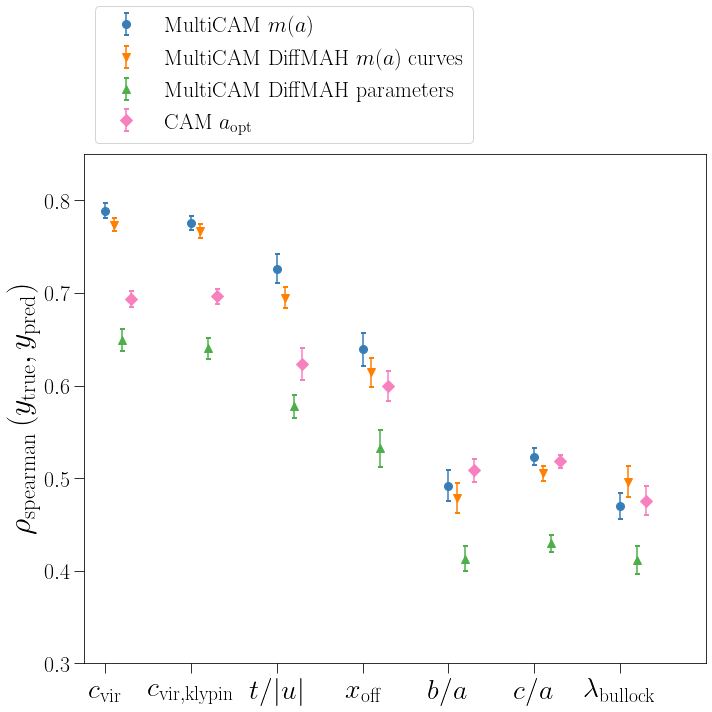

In [18]:
metrics_data = {
    "spear": {"yrange": (0.3, 0.85)},
    # "rscatter": {"yrange": (0.3, 1.0)},
    # "sigma_ratio": {"yrange": (0.8, 1.2), "hline": 1.0},
    # "mu": {"yrange": (-0.2, 0.2), "hline": 0.0},
}

markers = ["o", "v", "^", "D", "*"]
test_data = {
    "multicam_ma": (datasets["ma"]["test"][0], r"\rm MultiCAM $m(a)$", rxplots.cb_colors[0], markers[0]),
    # "multicam_am": (datasets["am"]["test"][0], r"\rm MultiCAM $a(m)$", rxplots.cb_colors[-1], markers[-1]),
    "multicam_diffmah_curves": (
        datasets["diffmah_curves"]["test"][0],
        r"\rm MultiCAM DiffMAH $m(a)$ curves",
        rxplots.cb_colors[1],
        markers[1],
    ),
    "multicam_diffmah_params": (
        datasets["diffmah_params"]["test"][0],
        r"\rm MultiCAM DiffMAH parameters",
        rxplots.cb_colors[2],
        markers[2],
    ),
    "mixed_cam": (
        datasets["am"]["test"][0],
        r"\rm CAM $a_{\rm opt}$",
        rxplots.cb_colors[3],
        markers[3],
    ),
}


fig = rxplots.metrics_plot(
    metrics_data,
    test_data,
    models,
    cat_test,
    params=params,
    ncols=1,
    nrows=1,
    figsize=(10, 10),
    ticksize=28,
    y_label_size=32,
    bbox_to_anchor=(0.0, 1.0, 0.45, 0.45),
    ms=8
)

fig.show()